In [1]:
import numpy as np
import matplotlib.pyplot as plt
import particles

In [2]:
# import distribution module
from particles import distributions as dists 

# import state space models module
from particles import state_space_models as ssm 

In [3]:
# define a class for the stochastic volatility model
class StochVol(ssm.StateSpaceModel): # subclass StateSpaceModel so that particles knows you are defining a model
    def PX0(self): # distribution of X0
        return dists.Normal(loc=0, scale=self.sigma / np.sqrt(1 - self.alpha**2))
    
    def PX(self, t, xp): # distribution of Xt | X_{t-1}=xp
        return dists.Normal(loc=self.alpha * xp, scale=self.sigma)
    
    def PY(self, t, xp, x): # distribution of Yt | X_{t-1}=xp, Xt=x
        return dists.Normal(loc=0, scale=self.beta * np.sqrt(np.exp(x)))    


In [4]:
# create a class instance with fixed parameter values
model = StochVol(beta=1, alpha=0.9, sigma=0.1)

In [5]:
# parameter values are now attributes of the model
model.beta, model.alpha, model.sigma

(1, 0.9, 0.1)

In [6]:
# simulate data from the model
T = 100
X, Y = model.simulate(T+1)

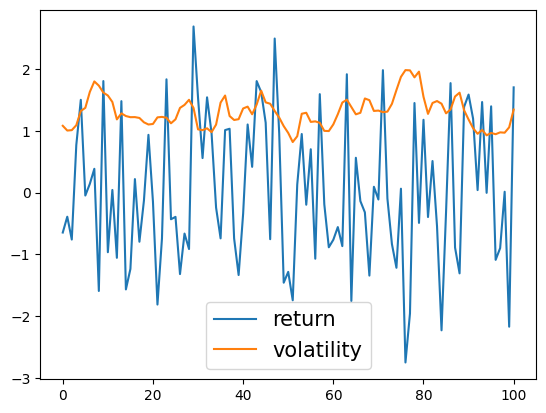

In [7]:
# plot the simulated data
plt.figure()
plt.plot(Y)
plt.plot(np.exp(X))
plt.legend(["return", "volatility"], fontsize=15)

In [8]:
# run bootstrap particle filter
fk = ssm.Bootstrap(ssm=model, data=Y) # fk is a FeynmanKac object, basically an algorithmic specification
N = 1000 # number of samples/particles 
resampling = "multinomial" # resampling scheme, better schemes are available! e.g. "systematic"
ESSrmin = 1.0 # we resample at every time step
pf = particles.SMC(fk=fk, N=N, resampling=resampling, ESSrmin=ESSrmin)
pf.run() # actual computation is done

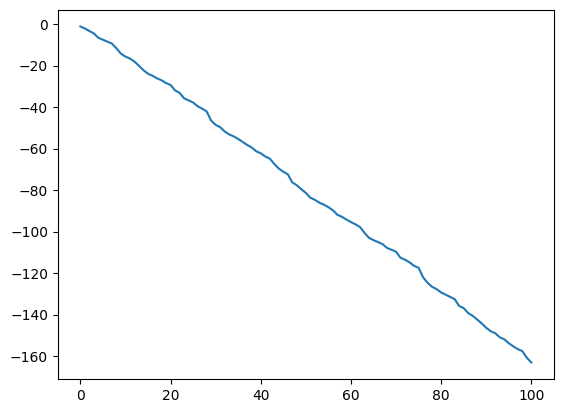

In [9]:
# log-likelihood estimates p(y0, y1, ..., yt)
plt.plot(pf.summaries.logLts)

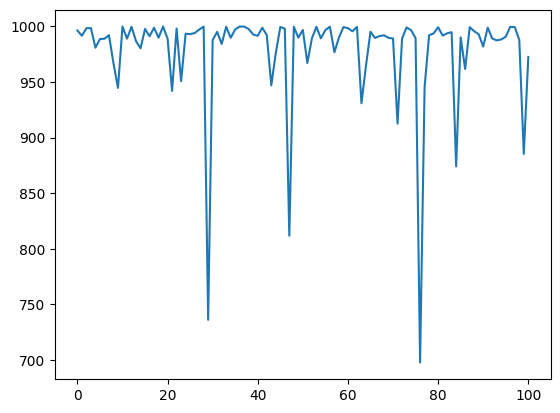

In [10]:
# effective sample size 
plt.plot(pf.summaries.ESSs) # suggests that algorithm is performing well because ESS is high

In [11]:
# get filtering means and variances
from particles.collectors import Moments
pf = particles.SMC(fk=fk, N=N, resampling=resampling, ESSrmin=ESSrmin, collect=[Moments()])
pf.run() # actual computation is done

In [12]:
# moments are stored in a list of size T+1
print(type(pf.summaries.moments))
print(len(pf.summaries.moments))

# each is a dict with keys "mean" and "var" giving us the filtering mean and variance 
print(pf.summaries.moments[0])

<class 'list'>
101
{'mean': -0.02849896132613619, 'var': 0.05022326682654155}


In [13]:
# extract all the filtering mean and variances
filtering_means = [m["mean"] for m in pf.summaries.moments]
filtering_vars = [m["var"] for m in pf.summaries.moments]

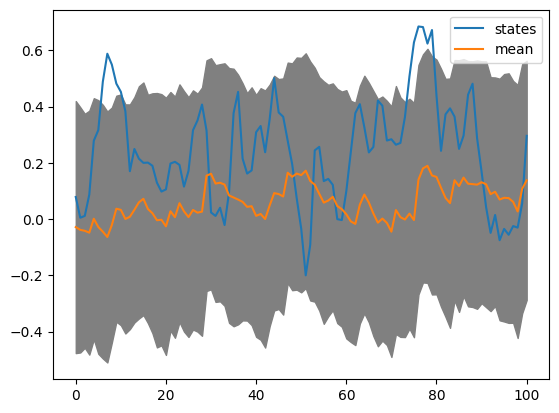

In [14]:
plt.figure()
plt.plot(X)
plt.plot(filtering_means)
time = np.arange(T+1)
plt.fill_between(
    time, 
    filtering_means - 2.0 * np.sqrt(filtering_vars), 
    filtering_means + 2.0 * np.sqrt(filtering_vars), 
    color = "gray",    
)
plt.legend(["states", "mean"])

In [21]:
# run particle filter and store its history of states and weights
pf = particles.SMC(fk=fk, N=N, resampling=resampling, ESSrmin=ESSrmin, collect=[Moments()], store_history=True)
pf.run() # actual computation is done

# run forward filtering and backward smoothing (FFBS)
M = 50 # number of trajectories
Z = pf.hist.backward_sampling_mcmc(M=M)
print(type(Z))
print(len(Z))

<class 'list'>
101


In [31]:
pf.hist

In [22]:
# convert list to numpy array
Z = np.array(Z)
Z.shape

(101, 50)

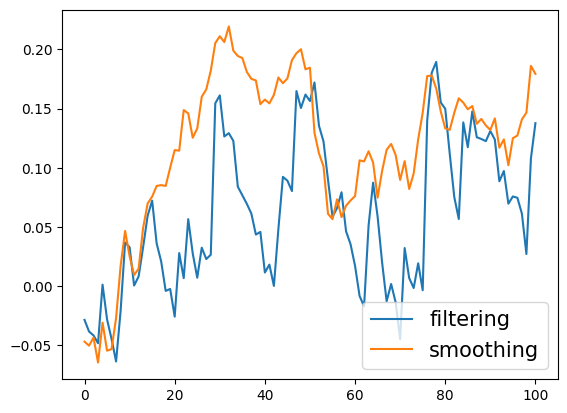

In [23]:
# approximate the smoothing mean
smoothing_means = np.mean(Z, axis=1)

# compare the filtering and smoothing means
plt.figure()
plt.plot(filtering_means)
plt.plot(smoothing_means)
plt.legend(["filtering", "smoothing"], fontsize=15)

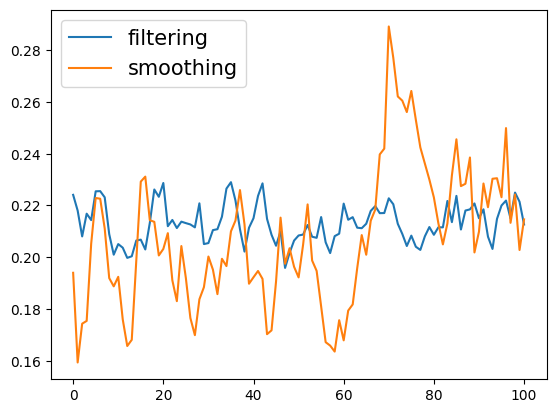

In [24]:
# approximate the smoothing variance
smoothing_vars = np.var(Z, axis=1)

# compare the filtering and smoothing standard deviations
plt.figure()
plt.plot(np.sqrt(filtering_vars))
plt.plot(np.sqrt(smoothing_vars))
plt.legend(["filtering", "smoothing"], fontsize=15)

In [25]:
# define a prior distribution of the parameters
prior_dict = {
    "beta": dists.Gamma(1, 1),
    "sigma": dists.Gamma(1, 1),
    "alpha": dists.Uniform(0, 1)
}
prior = dists.StructDist(prior_dict) # combines priors for each parameter independently

In [26]:
# particle marginal Metropolis-Hastings
from particles import mcmc # module for MCMC algorithms
Nx = 50 # number of samples/particles in the particle filter to approximate the likelihood function
niter = 1000 # number of MCMC iterations
pmmh = mcmc.PMMH(ssm_cls=StochVol, prior=prior, data=Y, Nx=Nx, niter=niter)
pmmh.run() # do the actual computation


In [27]:
# acceptance rate 
pmmh.acc_rate # looks good  

0.3963963963963964

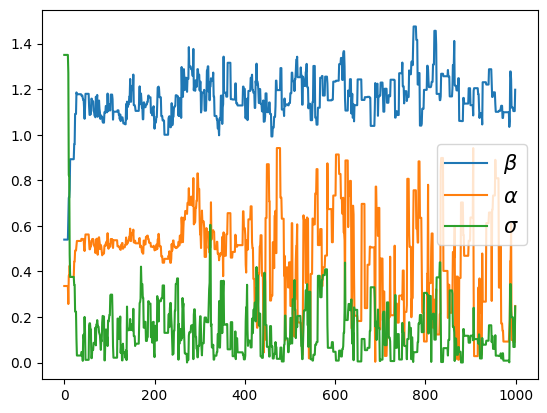

In [28]:
# parameters sampled from posterior (stored as a structured array)
# convergence diagnostics: trace plots
plt.plot(pmmh.chain.theta["beta"])
plt.plot(pmmh.chain.theta["alpha"])
plt.plot(pmmh.chain.theta["sigma"])
plt.legend(["$\\beta$", "$\\alpha$", "$\\sigma$"], fontsize=15)

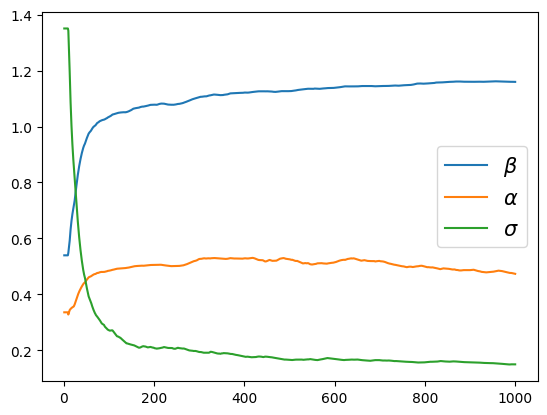

In [29]:
# convergence diagnostics: cummulative average over iterations
iterations = np.arange(1, niter+1)
plt.plot(iterations, np.cumsum(pmmh.chain.theta["beta"])/iterations)
plt.plot(iterations, np.cumsum(pmmh.chain.theta["alpha"])/iterations)
plt.plot(iterations, np.cumsum(pmmh.chain.theta["sigma"])/iterations)
plt.legend(["$\\beta$", "$\\alpha$", "$\\sigma$"], fontsize=15)

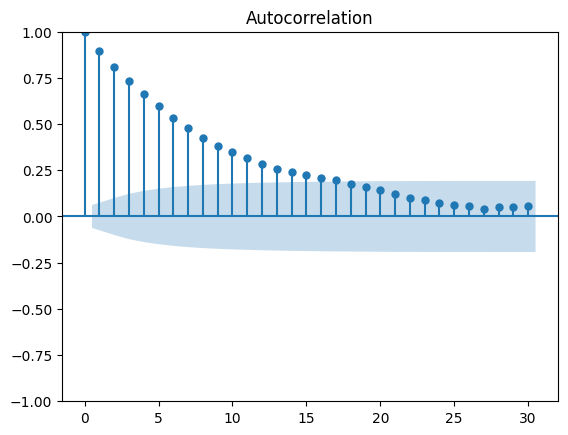

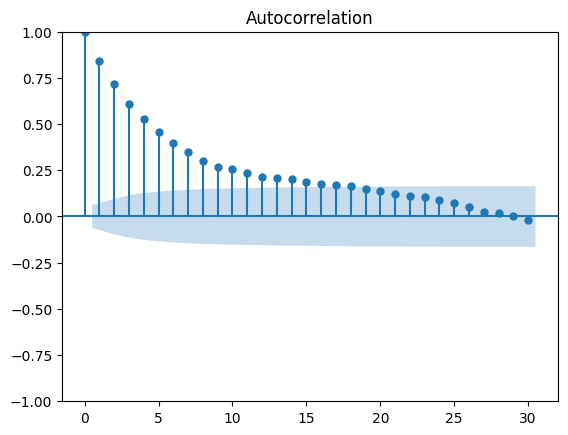

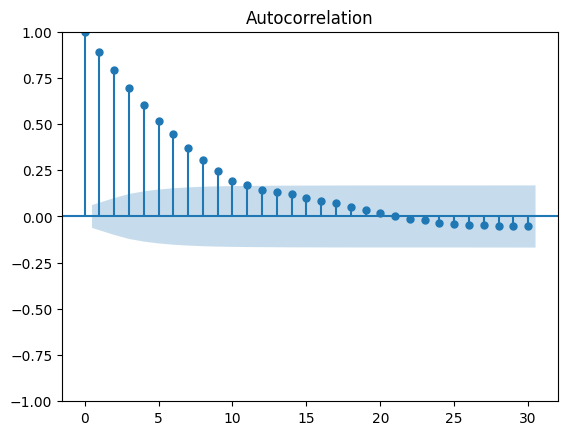

In [30]:
# convergence diagnostic: autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pmmh.chain.theta["beta"])
plot_acf(pmmh.chain.theta["alpha"])
plot_acf(pmmh.chain.theta["sigma"])
plt.show()